In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
eloss = pd.read_csv("/content/drive/MyDrive/Forecasting/energyloss.csv", index_col='Time', parse_dates=True) 
eloss

Value
Time                  
2010-01-01  62623.1960
2010-02-01  55850.2170
2010-03-01  57069.6450
2010-04-01  51282.6970
2010-05-01  54092.5900
...                ...
2022-09-01  41031.7113
2022-10-01  45584.7710
2022-11-01  58841.7691
2022-12-01  66539.4901
2023-01-01  56167.4992

[157 rows x 1 columns]

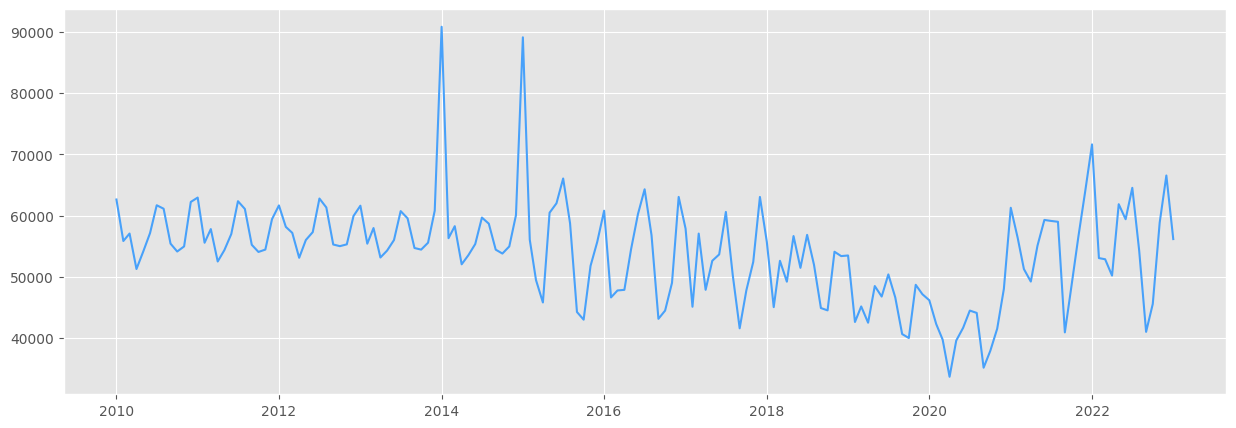

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(eloss, c='#48A1FA')
plt.show()

**Checking For stationarity**

**Histogram plot**

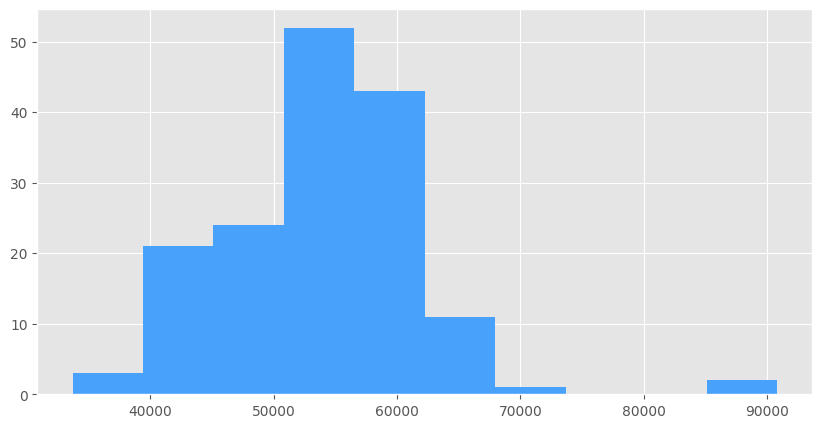

In [ ]:
pd.Series(eloss['Value']).hist(color="#48A1FA", figsize=(10,5));

**Checking Mean and Variance over small chunks**

In [ ]:
eloss_chunks = np.split(eloss['Value'][:-1], 12)
means = np.round(np.mean(eloss_chunks, axis=1), 2)
stds = np.round(np.std(eloss_chunks, axis=1), 2)
chunks_df = pd.DataFrame({'chunks': list(range(1, len(eloss_chunks)+1)), 'mean_values': means, 'variance_vals': stds})
chunks_df

chunks  mean_values  variance_vals
0        1     57735.39        3755.43
1        2     57204.38        3058.00
2        3     57556.37        2873.34
3        4     58977.80        9568.31
4        5     57802.21        9886.49
5        6     53799.20        7177.48
6        7     53510.72        6855.10
7        8     51900.65        5307.32
8        9     47213.74        4294.12
9       10     41605.40        4338.59
10      11     52798.78        6489.91
11      12     57204.22        8375.38

**Augumented Dicket-Fuller test**

In [ ]:
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, critical_vals, icbest = adfuller(eloss['Value'])

In [ ]:
print('P value',pval)
print(adf)
print(icbest)
print(usedlag)
print(critical_vals)

P value 0.4424170080065802
-1.6781248078599722
2836.78595041958
12
{'1%': -3.476597917537401, '5%': -2.8818291230495543, '10%': -2.5775887982253085}


**p > 0.005 => Time series is non-stationary**

**KPSS test**

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import kpss

# Perform the KPSS test
kpss_stat, p_value, lags, critical_values = kpss(eloss['Value'])

# Print the test results
print("KPSS Statistic:", kpss_stat)
print("p-value:", p_value)
print("Lags:", lags)
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

KPSS Statistic: 1.0760679853054156
p-value: 0.01
Lags: 5
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


**As P > 0.005 => Time series is non-stationary**

In [ ]:
eloss.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2010-01-01 to 2023-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   157 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


In [ ]:
import statsmodels.api as sm
from statsmodels.compat import lzip
const_array = np.ones_like(eloss)

reg_model = sm.OLS(eloss, const_array).fit()

# Calculate the residuals
residuals = reg_model.resid

bp_model = sm.OLS(residuals**2, const_array).fit()

# Perform the Breusch-Pagan test
bp_test = bp_model.get_robustcov_results(cov_type='HC1')
test_statistic = bp_test.bse[0]
p_value = bp_test.pvalues[0]

# Print the test results
print("Breusch-Pagan Test Results:")
print("Test Statistic:", test_statistic)
print("p-value:", p_value)

Breusch-Pagan Test Results:
Test Statistic: 12434313.178981539
p-value: 4.7058111043773845e-07


**As p < 0.005 => The time series is no-stationary and there is a high chance of Heteroscedasticity**

**Decomposition of time series into Trend, Seasonal, and Residuals components**

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=eloss, model = 'additive', period=12)
trend = ss_decomposition.trend
seasonal = ss_decomposition.seasonal
residual = ss_decomposition.resid

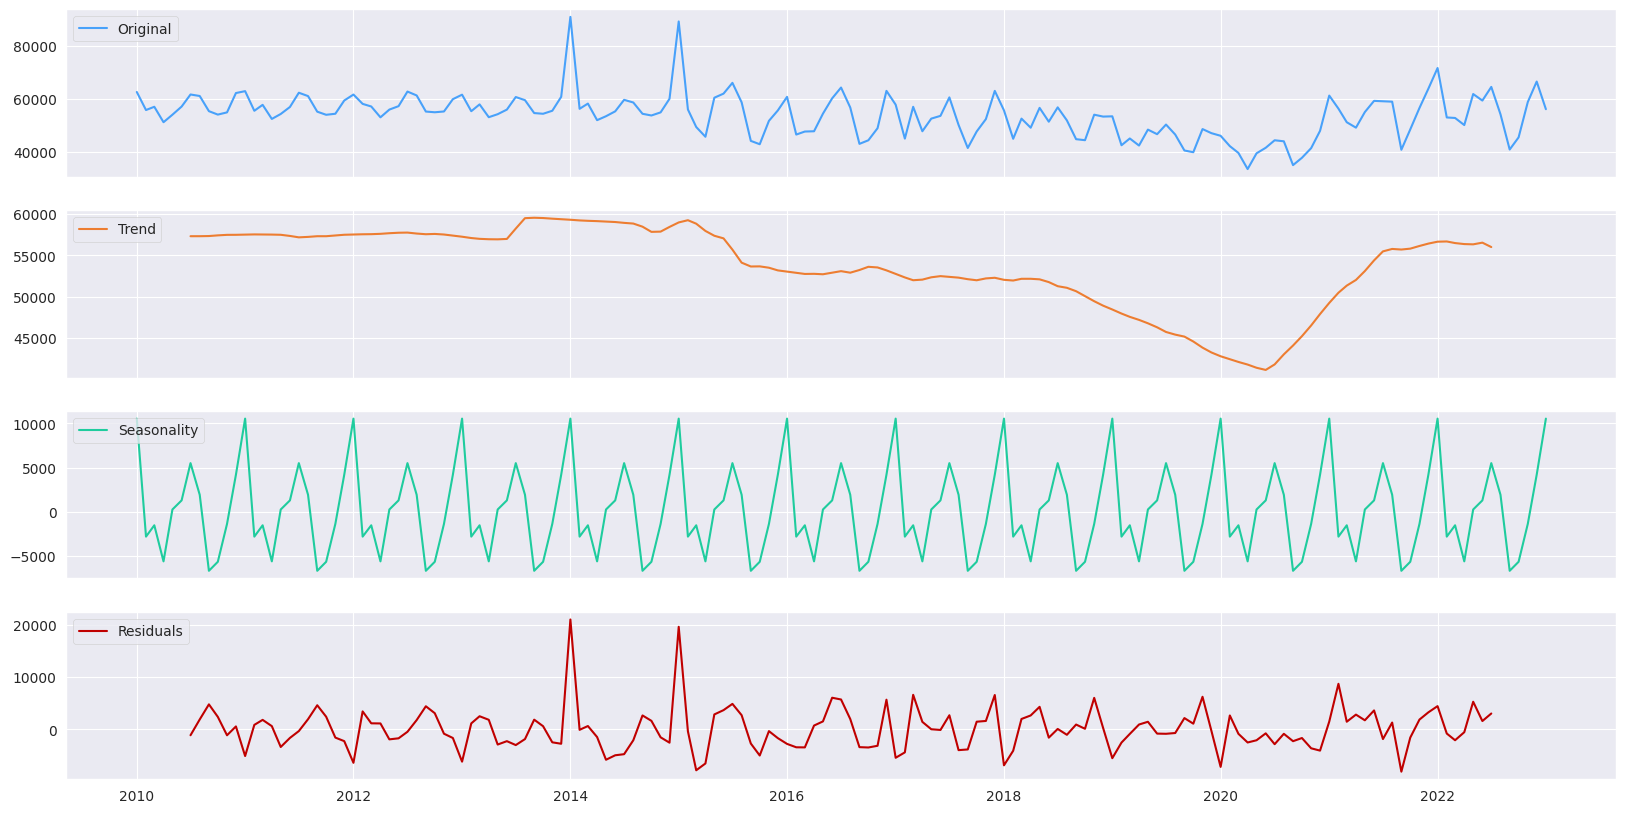

In [ ]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(20,10))

axes[0].plot(eloss.Value, label='Original', c="#48A1FA")
axes[0].legend(loc='upper left');

axes[1].plot(trend, label='Trend', c="#ED7D31")
axes[1].legend(loc='upper left');

axes[2].plot(seasonal, label='Seasonality', c="#1FCC9E")
axes[2].legend(loc='upper left');

axes[3].plot(residual, label='Residuals', c="#C00000")
axes[3].legend(loc='upper left');

**Rollin mean and standar deviation plots**

In [ ]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(18, 7))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic           -1.678125
p-value                   0.442417
Lags Used                12.000000
Observations Used       144.000000
Critical Value (1%)      -3.476598
Critical Value (5%)      -2.881829
Critical Value (10%)     -2.577589
dtype: float64


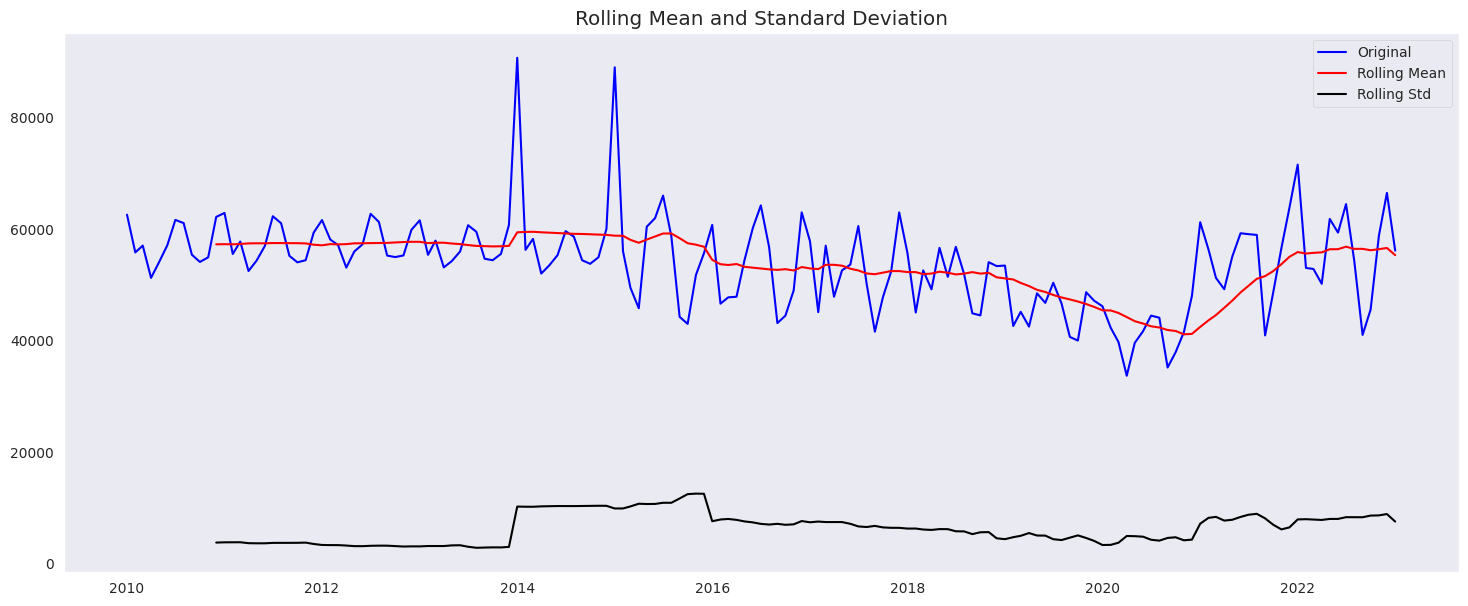

In [ ]:
dftest(eloss['Value'])

**Making Time Series statioanry by making necessary transformations**

In [ ]:
eloss['seasonal_difference'] = eloss['Value'].diff(12)

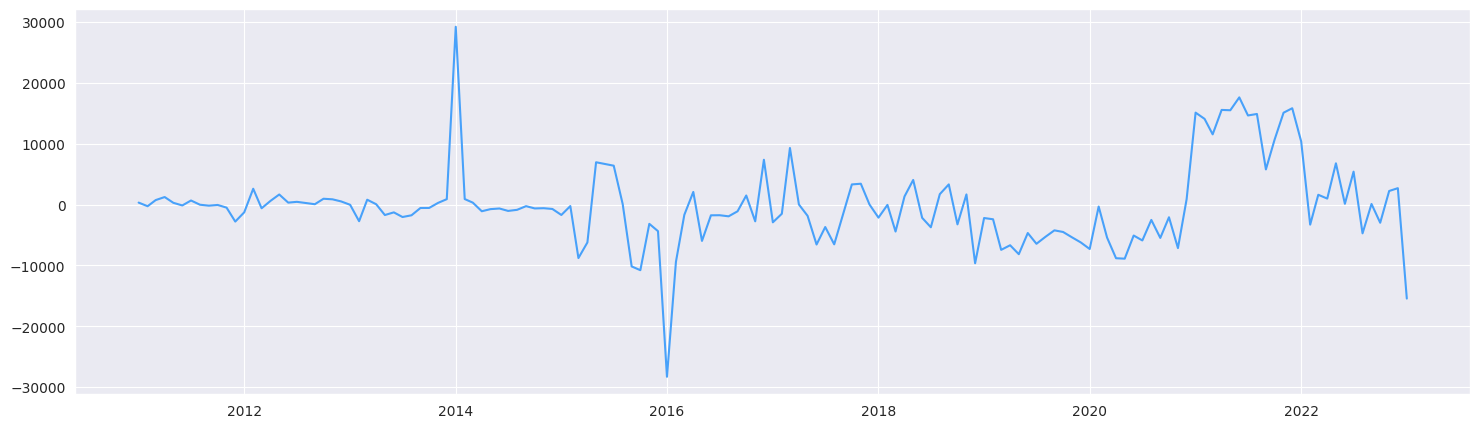

In [ ]:
fig, ax = plt.subplots(figsize=(18,5))
ax.plot(eloss.seasonal_difference, c='#48A1FA')
plt.show()

**Making all the values positive to apply log transformation**

In [ ]:
eloss['seasonal_difference_positive'] = eloss['seasonal_difference'] + 30000
eloss.seasonal_difference_positive

Time
2010-01-01           NaN
2010-02-01           NaN
2010-03-01           NaN
2010-04-01           NaN
2010-05-01           NaN
                 ...    
2022-09-01    30087.1712
2022-10-01    27005.0170
2022-11-01    32219.5595
2022-12-01    32685.1687
2023-01-01    14552.3364
Name: seasonal_difference_positive, Length: 157, dtype: float64

In [ ]:
eloss['log_transformed'] = np.log(eloss.seasonal_difference_positive)

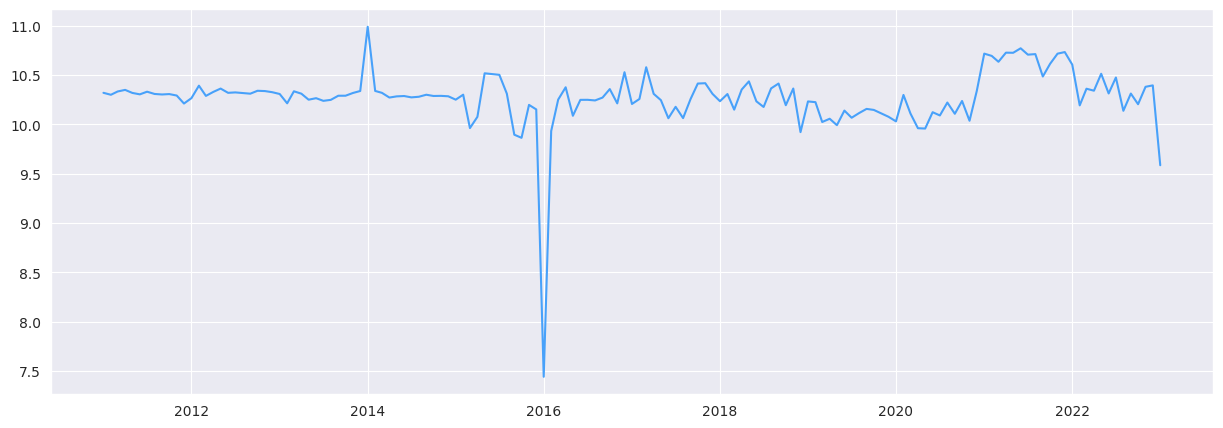

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(eloss.log_transformed, c='#48A1FA')
plt.show()

**Now it looks like stationary, let's confirm with ADF, KPSS and Breusch-Pagan Tests**

**ADF test**

In [ ]:
adf1, pval1, usedlag1, nobs1, critical_vals1, icbest1 = adfuller(eloss['log_transformed'][12:])
print('P value',pval1)
print(adf1)
print(icbest1)
print(usedlag1)
print(critical_vals1)

P value 0.004914033815606926
-3.6475723929498374
64.19361269189548
3
{'1%': -3.4776006742422374, '5%': -2.882265832283648, '10%': -2.5778219289774156}


**KPSS test**

In [ ]:
# Perform the KPSS test
kpss_stat1, p_value1, lags1, critical_values1 = kpss(eloss['log_transformed'][12:])

# Print the test results
print("KPSS Statistic:", kpss_stat1)
print("p-value:", p_value1)
print("Lags:", lags1)
print("Critical Values:")
for key, value in critical_values1.items():
    print(f"  {key}: {value}")

KPSS Statistic: 0.14244763790521725
p-value: 0.1
Lags: 6
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [ ]:
const_array1 = np.ones_like(eloss.log_transformed[12:])
reg_model1 = sm.OLS(eloss.log_transformed[12:], const_array1).fit()

# Calculate the residuals
residuals1 = reg_model1.resid

bp_model1 = sm.OLS(residuals1**2, const_array1).fit()

# Perform the Breusch-Pagan test
bp_test1 = bp_model1.get_robustcov_results(cov_type='HC1')
test_statistic1 = bp_test1.bse[0]
p_value1 = bp_test1.pvalues[0]

# Print the test results
print("Breusch-Pagan Test Results:")
print("Test Statistic:", test_statistic1)
print("p-value:", p_value1)

Breusch-Pagan Test Results:
Test Statistic: 0.055284533519155805
p-value: 0.0911422005248068


In [ ]:
from tabulate import tabulate

adf_pvalue = 0.004914033815606926
kpss_pvalue = 0.1
bp_pvalue = 0.0911422005248068

data = [
    ['ADF Test', adf_pvalue],
    ['KPSS Test', kpss_pvalue],
    ['Breusch-Pagan Test', bp_pvalue]
]

print(tabulate(data, headers=['Test', 'p-value'], tablefmt='fancy_grid'))


╒════════════════════╤════════════╕
│ Test               │    p-value │
╞════════════════════╪════════════╡
│ ADF Test           │ 0.00491403 │
├────────────────────┼────────────┤
│ KPSS Test          │ 0.1        │
├────────────────────┼────────────┤
│ Breusch-Pagan Test │ 0.0911422  │
╘════════════════════╧════════════╛


**All the test say's Time Series is Stationary**

**Decomposing the transformed time series**

In [ ]:
ss_decomposition1 = seasonal_decompose(x=eloss.log_transformed[12:], model = 'additive', period=12)
trend1 = ss_decomposition1.trend
seasonal1 = ss_decomposition1.seasonal
residual1 = ss_decomposition1.resid

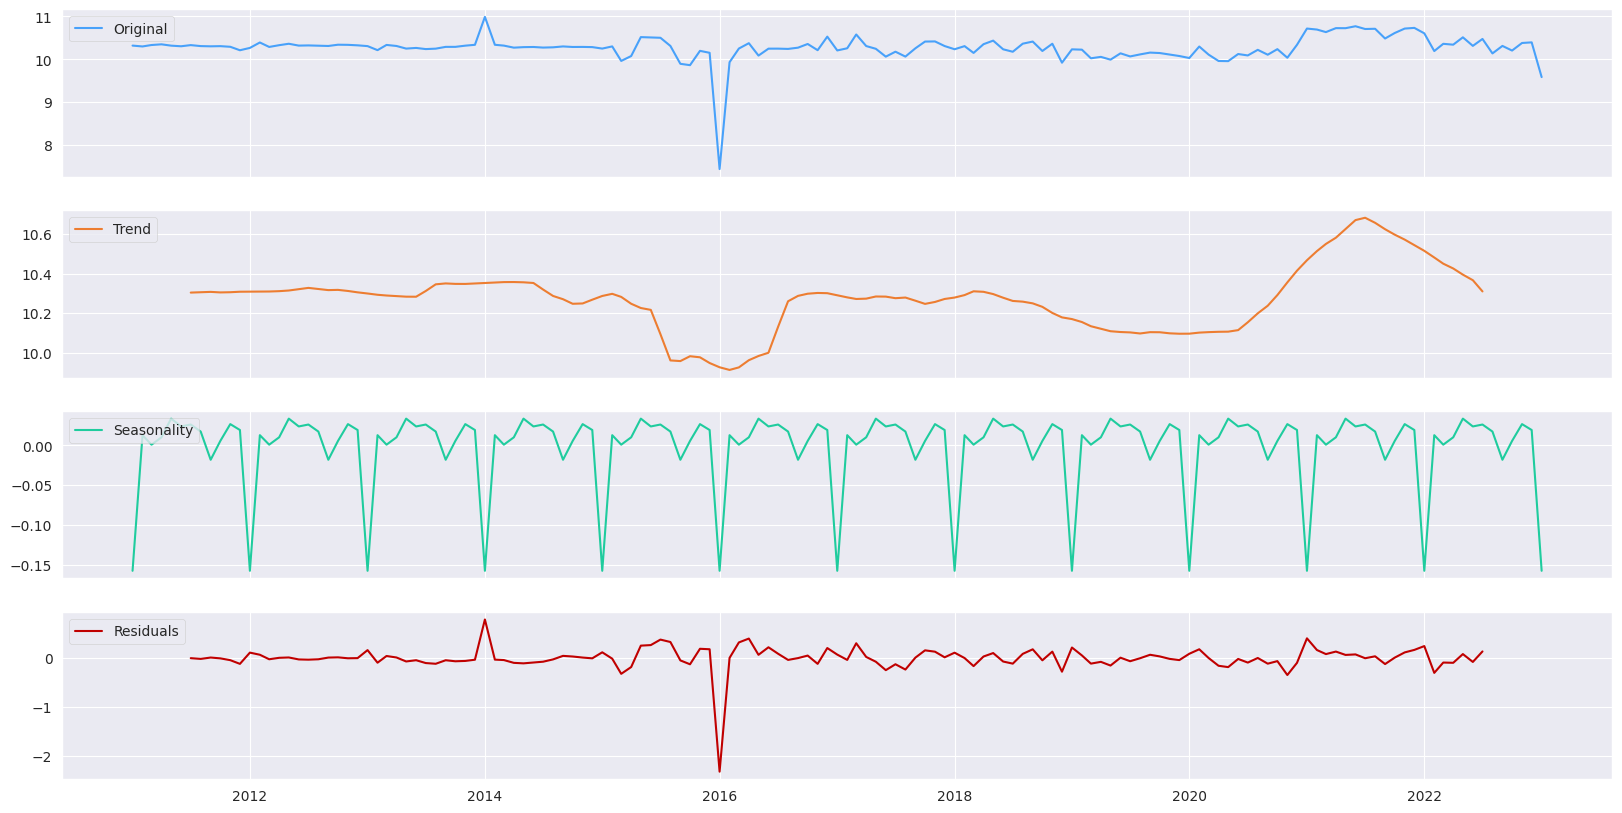

In [ ]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(20,10))

axes[0].plot(eloss.log_transformed[12:], label='Original', c="#48A1FA")
axes[0].legend(loc='upper left');

axes[1].plot(trend1, label='Trend', c="#ED7D31")
axes[1].legend(loc='upper left');

axes[2].plot(seasonal1, label='Seasonality', c="#1FCC9E")
axes[2].legend(loc='upper left');

axes[3].plot(residual1, label='Residuals', c="#C00000")
axes[3].legend(loc='upper left');

**Still there is a seasonal component, so let's go with SARIMA model**

**ACF and PACF plots**

In [ ]:
from statsmodels.graphics.tsaplots import acf, plot_acf

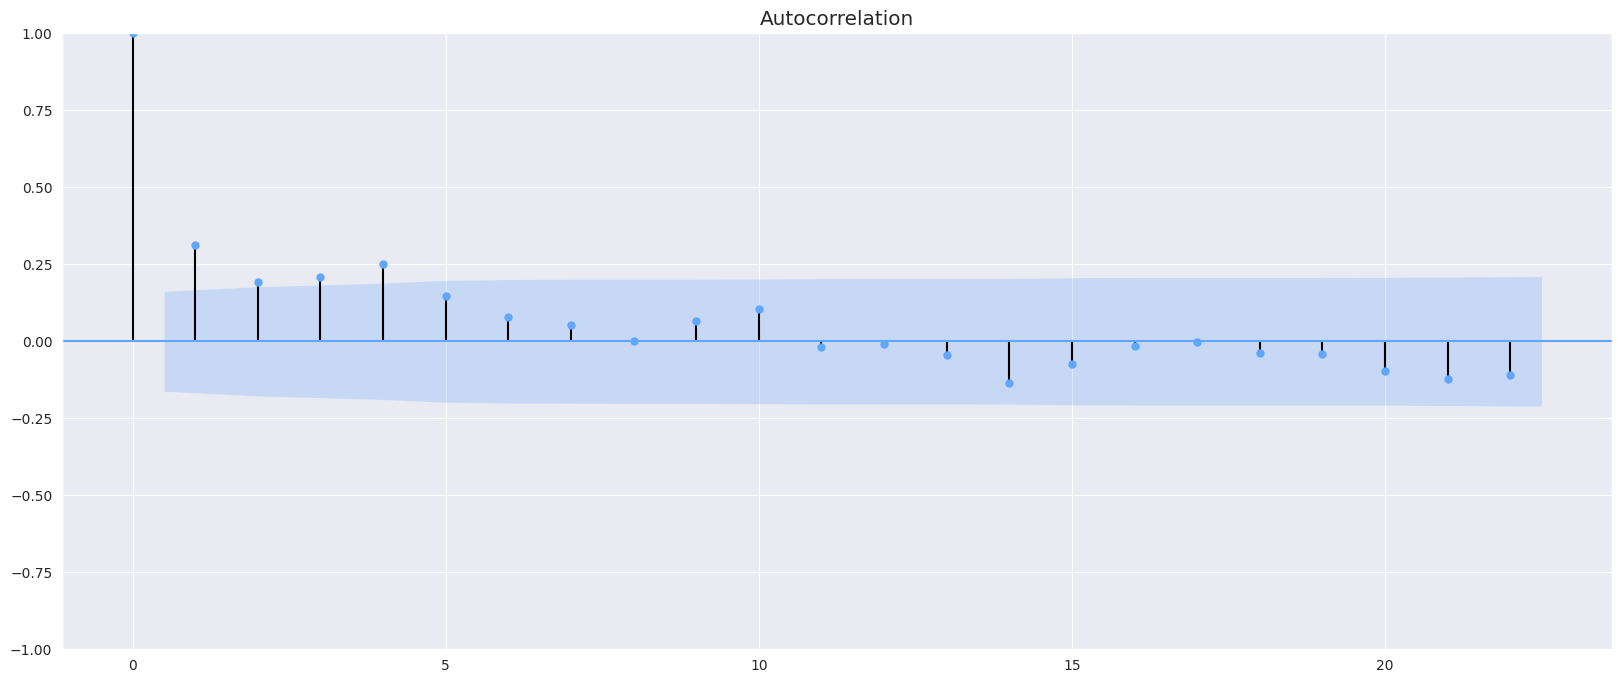

In [ ]:
from matplotlib.collections import PolyCollection
fig, ax = plt.subplots(figsize=(20,8))
plot_acf(eloss.log_transformed[12:], ax=ax, 
         color='#60A6FB',  
         vlines_kwargs={"colors": '#000000'})

for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('#60A6FB')

plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import pacf, plot_pacf

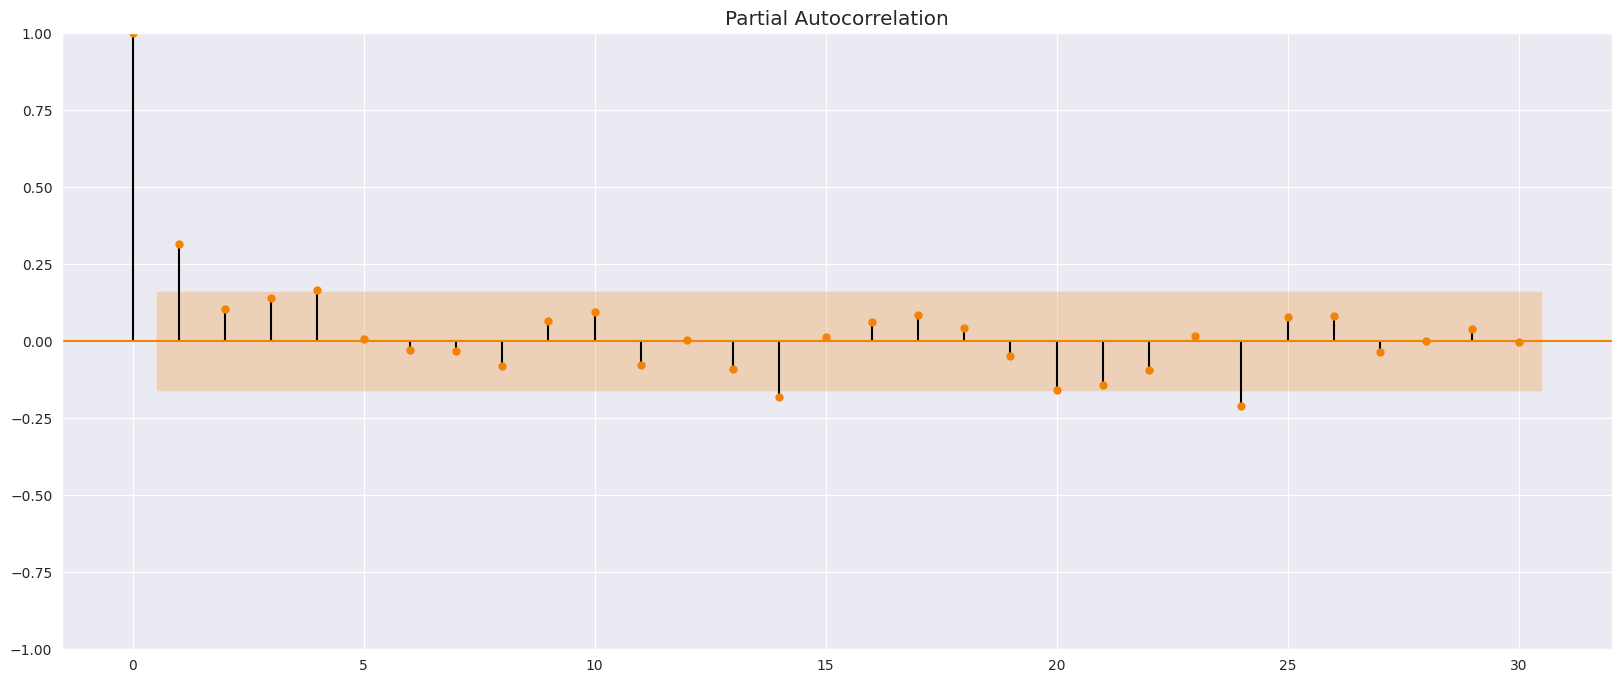

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

plot_pacf(eloss.log_transformed[12:], 
          lags=30, ax=ax, color='#F38307',  
          vlines_kwargs={"colors": '#000000'})

for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor('#F38307')

plt.show()

**As these plots are for transformed time series, we should keep in mind about first seasonal difference we have done**

**Lest use Auto ARIMA to select the best parameters**

In [ ]:
!pip install git+https://github.com/statsmodels/statsmodels.git
!pip install pmdarima
import pmdarima as pm
#!pip install pmdarima-1.7.1-cp37-cp37m-win_amd64.whl
#from pyramid.arima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/statsmodels/statsmodels.git to /tmp/pip-req-build-qls6qdnv
  Running command git clone --filter=blob:none --quiet https://github.com/statsmodels/statsmodels.git /tmp/pip-req-build-qls6qdnv
  Resolved https://github.com/statsmodels/statsmodels.git to commit 2a3727c6f9ce56819eda194f05e2b625facbf896
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for statsmodels: filename=statsmodels-0.15.0.dev6+g2a3727c6f-cp310-cp310-linux_x86_64.whl size=23234409 sha256=9be6b239a5f40e4eb90cdbab6a912775102eca3c854e76147dce430488f7c432
  Stored in directory: /tmp/pip-ephem-wheel-cache-uhrx0skr/wheels/63/99/aa/bb07110a6e10e2d86fabb8c067f39ed97d662d486bb01ca22b
Successfully built statsmodels
  Attempting uninstall: statsmodels
    Found e

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.3 MB/s eta 0:00:00


In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

# Assuming you have a pandas DataFrame or Series containing your time series data
# Make sure the index is set to the appropriate datetime format

# Load your time series data into a pandas DataFrame or Series
# For example, let's assume we have monthly data in a DataFrame named 'df'
# with a column named 'value' containing the values

# Split the data into training and testing sets
train_data = eloss['log_transformed'][12:]

# Define the parameter ranges for grid search
p_range = range(0, 3)  # Autoregressive order
d_range = range(0, 2)  # Differencing order
q_range = range(0, 6)  # Moving average order
P_range = range(0, 3)  # Seasonal autoregressive order
D_range = range(0, 2)  # Seasonal differencing order
Q_range = range(0, 3)  # Seasonal moving average order
s = 12  # Seasonal period

# Perform grid search to find the best parameters
model = pm.auto_arima(train_data, start_p=1, start_q=1, max_p=5, max_q=5,
                      start_P=0, start_D=0, start_Q=0, max_P=5, max_D=5, max_Q=5,
                      seasonal=True, m=s, stepwise=True, suppress_warnings=True)

# Get the best model parameters
best_order = model.order
best_seasonal_order = model.seasonal_order

print("Best SARIMA order:", best_order)
print("Best seasonal order:", best_seasonal_order)

Best SARIMA order: (1, 0, 1)
Best seasonal order: (0, 0, 0, 12)


In [ ]:
# fit SARIMA monthly based on helper plots
sarima = sm.tsa.statespace.SARIMAX(eloss.log_transformed, 
                                order=(1,0,1), 
                                seasonal_order=(0,0,0,12), 
                                trend='c').fit()
sarima.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_transformed   No. Observations:                  157
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -24.326
Date:                Fri, 12 May 2023   AIC                             56.652
Time:                        02:28:06   BIC                             68.877
Sample:                    01-01-2010   HQIC                            61.617
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5104      1.667      1.506      0.132      -0.758       5.778
ar.L1          0.7554      0.163      4.648      0.000       0.437       1.074
ma.L1         -0.5150      0.206     -2.499      0.012      -0.919      -0.111
sigma2         0.0816      0.003     26.874      0.000       0.076       0.088
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             26311.51
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               3.78   Skew:                            -6.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        65.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

# Assuming you have a pandas DataFrame or Series containing your time series data
# Make sure the index is set to the appropriate datetime format

# Load your time series data into a pandas DataFrame or Series
# For example, let's assume we have monthly data in a DataFrame named 'df'
# with a column named 'value' containing the values

# Split the data into training and testing sets
train_data1, test_data1 = train_test_split(eloss['log_transformed'][12:], test_size=0.2)

# Define the parameter ranges for grid search
p_range = range(0, 3)  # Autoregressive order
d_range = range(0, 2)  # Differencing order
q_range = range(0, 5)  # Moving average order
P_range = range(0, 3)  # Seasonal autoregressive order
D_range = range(0, 2)  # Seasonal differencing order
Q_range = range(0, 3)  # Seasonal moving average order
s = 12  # Seasonal period

# Perform grid search to find the best parameters
model1 = pm.auto_arima(train_data1, start_p=1, start_q=1, max_p=5, max_q=5,
                      start_P=0, start_D=0, start_Q=0, max_P=5, max_D=5, max_Q=5,
                      seasonal=True, m=s, stepwise=True, suppress_warnings=True)

# Get the best model parameters
best_order1 = model1.order
best_seasonal_order1 = model1.seasonal_order

print("Best SARIMA order:", best_order1)
print("Best seasonal order:", best_seasonal_order1)

Best SARIMA order: (1, 0, 0)
Best seasonal order: (0, 0, 0, 12)


**Based on ACF and PACF plots**

In [ ]:
# fit SARIMA monthly based on helper plots
sarima_1 = sm.tsa.statespace.SARIMAX(eloss.log_transformed, 
                                order=(1,0,4), 
                                seasonal_order=(0,0,0,12), 
                                trend='c').fit()
sarima_1.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        log_transformed   No. Observations:                  157
Model:               SARIMAX(1, 0, 4)   Log Likelihood                 -22.226
Date:                Fri, 12 May 2023   AIC                             58.451
Time:                        02:33:32   BIC                             79.845
Sample:                    01-01-2010   HQIC                            67.140
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.9821      6.305      0.949      0.343      -6.375      18.339
ar.L1          0.4173      0.615      0.679      0.497      -0.787       1.622
ma.L1         -0.1711      0.634     -0.270      0.787      -1.414       1.072
ma.L2          0.0389      0.199      0.196      0.845      -0.350       0.428
ma.L3          0.1056      0.130      0.810      0.418      -0.150       0.361
ma.L4          0.1967      0.149      1.320      0.187      -0.095       0.489
sigma2         0.0798      0.006     13.114      0.000       0.068       0.092
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             21064.17
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.65   Skew:                            -5.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        58.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**As we got AIC value less for sarima(model) i.e form Auto ARIMA; we will proceed with that model**

In [ ]:
eloss.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2010-01-01 to 2023-01-01
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Value                         157 non-null    float64
 1   seasonal_difference           145 non-null    float64
 2   seasonal_difference_positive  145 non-null    float64
 3   log_transformed               145 non-null    float64
dtypes: float64(4)
memory usage: 6.1 KB


In [ ]:
# fit SARIMA monthly based on helper plots
sarima_temp = sm.tsa.statespace.SARIMAX(eloss.log_transformed, 
                                order=(1,0,0), 
                                seasonal_order=(2,0,0,12), 
                                trend='c').fit()
sarima_temp.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    log_transformed   No. Observations:                  157
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood                 -21.112
Date:                            Fri, 12 May 2023   AIC                             52.223
Time:                                    03:58:37   BIC                             67.504
Sample:                                01-01-2010   HQIC                            58.429
                                     - 01-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.7753      1.702      5.156      0.000       5.439      12.111
ar.L1          0.3111      0.055      5.612      0.000       0.202       0.420
ar.S.L12       0.0241      0.221      0.109      0.913      -0.409       0.457
ar.S.L24      -0.2655      0.036     -7.462      0.000      -0.335      -0.196
sigma2         0.0773      0.003     22.925      0.000       0.071       0.084
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):             20783.12
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               3.45   Skew:                            -5.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        58.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
eloss['tem_forecast'] = sarima.predict(start = 0, end= eloss.shape[0])

In [ ]:
eloss.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2010-01-01 to 2023-01-01
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Value                         157 non-null    float64
 1   seasonal_difference           145 non-null    float64
 2   seasonal_difference_positive  145 non-null    float64
 3   log_transformed               145 non-null    float64
 4   tem_forecast                  157 non-null    float64
dtypes: float64(5)
memory usage: 7.4 KB


In [ ]:
eloss['tem_forecast_2'] = np.exp(eloss['tem_forecast'])

In [ ]:
eloss['tem_forecast_3'] = eloss['tem_forecast_2'] - 30000

In [ ]:
eloss['Forecast'] = eloss['tem_forecast_3'].shift(12) + eloss['Value'].iloc[12:]

In [ ]:
eloss.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145 entries, 2011-01-01 to 2023-01-01
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Value                         145 non-null    float64
 1   seasonal_difference           145 non-null    float64
 2   seasonal_difference_positive  145 non-null    float64
 3   log_transformed               145 non-null    float64
 4   tem_forecast                  145 non-null    float64
 5   tem_forecast_2                145 non-null    float64
 6   tem_forecast_3                145 non-null    float64
 7   tem_forecast_4                145 non-null    float64
 8   tem_forecast_5                145 non-null    float64
 9   Value_scaled                  145 non-null    float64
 10  Forecast_scaled               145 non-null    float64
 11  Forecast                      133 non-null    float64
dtypes: float64(12)
memory usage: 18.8 KB


In [ ]:
eloss['tem_forecast_5'] = eloss['tem_forecast_3'].shift(12) + eloss['seasonal_difference']

In [ ]:
eloss.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157 entries, 2010-01-01 to 2023-01-01
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Value                         157 non-null    float64
 1   seasonal_difference           145 non-null    float64
 2   seasonal_difference_positive  145 non-null    float64
 3   log_transformed               145 non-null    float64
 4   tem_forecast                  157 non-null    float64
 5   tem_forecast_2                157 non-null    float64
 6   tem_forecast_3                157 non-null    float64
 7   tem_forecast_4                145 non-null    float64
 8   tem_forecast_5                145 non-null    float64
dtypes: float64(9)
memory usage: 16.3 KB


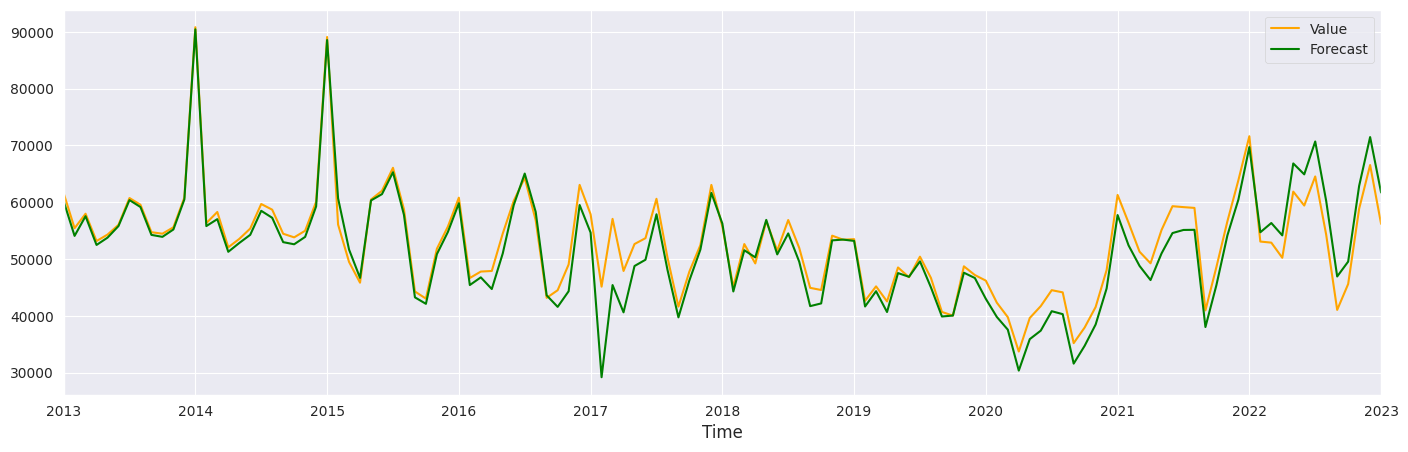

In [ ]:
# plot predictions
pd.plotting.register_matplotlib_converters()
#use model.predict() start and end in relation to series 
eloss[12:][['Value', 'Forecast']].plot(color = ('orange','g'), figsize = (17,5));

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming eloss['Forecast'] and eloss['Value'] have the same length
mse = mean_squared_error(eloss['Value'][12:], eloss['Forecast'][12:])
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 3064.1610234904533


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# Drop rows with null values
eloss = eloss.dropna()

# Calculate MAPE
mape = mean_absolute_percentage_error(eloss['Value'][12:], eloss['Forecast'][12:]) * 100
print("MAPE:", mape)

MAPE: 4.561183818447113


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Drop rows with null values
eloss = eloss.dropna()

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_eloss = scaler.fit_transform(eloss[['Value', 'Forecast']])
eloss['Value_scaled'] = scaled_eloss[:, 0]
eloss['Forecast_scaled'] = scaled_eloss[:, 1]

# Calculate RMSE on scaled data
mse = mean_squared_error(eloss['Value_scaled'][12:], eloss['Forecast_scaled'][12:])
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 0.05725921384757323


In [ ]:
from tabulate import tabulate

# Assuming you have the MAPE, RMSE, and MinMax scaled RMSE values stored in variables
mape = 4.561183818447113
rmse = 3064.1610234904533
rmse_minmax = 0.05725921384757323

# Create a table as a list of lists
table = [
    ["MAPE", mape],
    ["RMSE", rmse],
    ["RMSE (MinMax Scaled)", rmse_minmax]
]

# Specify the table headers
headers = ["Metric", "Value"]

# Generate the table
table_str = tabulate(table, headers, tablefmt="fancy_grid")

# Print the table
print(table_str)


╒══════════════════════╤══════════════╕
│ Metric               │        Value │
╞══════════════════════╪══════════════╡
│ MAPE                 │    4.56118   │
├──────────────────────┼──────────────┤
│ RMSE                 │ 3064.16      │
├──────────────────────┼──────────────┤
│ RMSE (MinMax Scaled) │    0.0572592 │
╘══════════════════════╧══════════════╛
